純LSTM  用來證明predict出來的直會延遲

In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd 
import numpy as np

stock_codes = [1102]


stock_code = str(stock_codes[0])
dataset_train = pd.read_csv('data/stock/'+stock_code+'.csv')
dataset_train = dataset_train[:600]
training_set = dataset_train['close'].to_frame()
y_t = dataset_train['close'].to_frame()



sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
y_t_scaled = sc.fit_transform(y_t)
print(y_t_scaled[30,0])
x_train = []
y_train = []
for i in range(30,len(dataset_train)):
    x_train.append(training_set_scaled[i-30:i,0])
    y_train.append(y_t_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape)

0.23566378633150054
(570, 30, 1)


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,LSTM
from keras import optimizers

# Adding the first LSTM layer and some Dropout regularisation
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#regressor.add(Dense(units = 3))
#regressor.add(Dense(3,activation='softmax'))
regressor.add(Dense(units = 1))

regressor.summary()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 50)            0         
_______________________________________

In [3]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(x_train, y_train, epochs = 64, batch_size = 64)


Epoch 1/64
570/570 [==============================] - 1s 2ms/step - loss: 0.0894
Epoch 2/64
570/570 [==============================] - 0s 556us/step - loss: 0.0237
Epoch 3/64
570/570 [==============================] - 0s 565us/step - loss: 0.0171
Epoch 4/64
570/570 [==============================] - 0s 548us/step - loss: 0.0149 0s - loss: 0.01
Epoch 5/64
570/570 [==============================] - 0s 555us/step - loss: 0.0133
Epoch 6/64
570/570 [==============================] - 0s 532us/step - loss: 0.0117
Epoch 7/64
570/570 [==============================] - 0s 535us/step - loss: 0.0116
Epoch 8/64
570/570 [==============================] - 0s 535us/step - loss: 0.0103
Epoch 9/64
570/570 [==============================] - 0s 535us/step - loss: 0.0102
Epoch 10/64
570/570 [==============================] - 0s 534us/step - loss: 0.0107
Epoch 11/64
570/570 [==============================] - 0s 537us/step - loss: 0.0091
Epoch 12/64
570/570 [==============================] - 0s 550us/step -

In [4]:
stock_codes = [1102]
x_test = []
real_stock_price= []

stock_code = str(stock_codes[0])
df = pd.read_csv('data/stock/'+stock_code+'.csv')
dataset_test = df[600:]

real_stock_price = dataset_test['close'].to_frame().values




dataset_total = pd.concat((dataset_train['close'].to_frame(), dataset_test['close'].to_frame()), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 30:].values

# inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(30, len(dataset_test)+30):  # timesteps一樣60； 80 = 先前的60天資料+2017年的20天資料
    X_test.append(inputs[i-30:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 


print(X_test.shape)

(107, 30, 1)


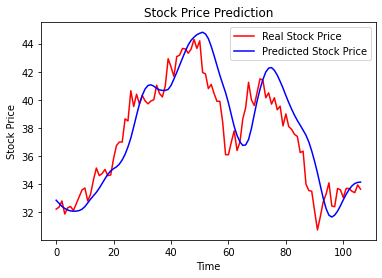

In [5]:
import matplotlib.pyplot as plt 
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')  # 紅線表示真實股價
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')  # 藍線表示預測股價
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error
print('MSE：',mean_squared_error(real_stock_price,predicted_stock_price))
#print('MAE:',np.median(np.abs(real_stock_price-predicted_stock_price)))
print('r squared:',1- mean_squared_error(real_stock_price,predicted_stock_price)/ np.var(real_stock_price))
mape = np.mean(np.abs((real_stock_price - predicted_stock_price) / real_stock_price)) * 100
print('mape:', mape)

MSE： 2.9859151389454475
r squared: 0.781888225267094
mape: 3.605611177443423


In [7]:
def dc(r,p):
    total = 0
    for i in range(1,len(r)):
        if (r[i-1]-r[i])*(p[i-1]-p[i]) >= 0:
            tmp = 1
        else:
            tmp = 0
        total += tmp
    result = total/(len(r)-1)*100
    return result

a = dc(real_stock_price,predicted_stock_price)
print(a)
print(real_stock_price)
print('==========')
print(predicted_stock_price)

58.490566037735846
[[32.23]
 [32.37]
 [32.81]
 [31.88]
 [32.32]
 [32.42]
 [32.13]
 [32.61]
 [33.1 ]
 [33.59]
 [33.73]
 [32.81]
 [33.3 ]
 [34.32]
 [35.15]
 [34.61]
 [34.76]
 [35.05]
 [34.61]
 [34.66]
 [35.83]
 [36.75]
 [37.  ]
 [37.  ]
 [38.65]
 [38.5 ]
 [40.65]
 [39.53]
 [40.4 ]
 [39.72]
 [40.31]
 [39.92]
 [39.72]
 [39.92]
 [40.01]
 [41.04]
 [40.45]
 [40.21]
 [40.99]
 [42.93]
 [42.35]
 [41.67]
 [43.08]
 [43.18]
 [43.66]
 [43.62]
 [43.32]
 [43.62]
 [44.3 ]
 [43.66]
 [44.2 ]
 [41.95]
 [41.85]
 [40.8 ]
 [41.1 ]
 [40.45]
 [39.9 ]
 [39.9 ]
 [38.4 ]
 [36.1 ]
 [36.1 ]
 [37.  ]
 [37.8 ]
 [36.4 ]
 [37.  ]
 [38.65]
 [39.45]
 [41.25]
 [40.  ]
 [39.6 ]
 [40.55]
 [41.5 ]
 [41.4 ]
 [40.15]
 [40.5 ]
 [39.7 ]
 [40.15]
 [39.3 ]
 [39.55]
 [38.15]
 [39.  ]
 [38.1 ]
 [37.9 ]
 [37.55]
 [37.4 ]
 [36.25]
 [36.35]
 [34.  ]
 [33.55]
 [33.5 ]
 [32.1 ]
 [30.75]
 [31.7 ]
 [32.75]
 [33.3 ]
 [34.1 ]
 [32.45]
 [32.4 ]
 [33.7 ]
 [33.6 ]
 [33.05]
 [33.7 ]
 [33.7 ]
 [33.5 ]
 [33.4 ]
 [33.95]
 [33.65]]
[[32.861702]
 [32